# Plotting History of Robot States

This script should extract the data history.p in the ./data folder

Data:
see below and IDM.py for what arrays are included

Jake Sganga
2/4/2016


In [1]:
%matplotlib inline

import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import mpld3
# mpld3.enable_notebook()

# from matplotlib import rc
# # rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# ## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
# # rc('text', usetex=True)

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

sns.set_style("white")
sns.set_context("talk")

blue, green, red, purple = sns.color_palette("deep")[:4]
color_list = [blue, green, red, purple]
grey = [0.7, 0.725, 0.725]

from load_history import history_data

sys.path.append('..')
from robot.model.model_physics import catheter
from robot.model.environment import environment
robot = catheter()
lung  = environment()

## Lung Environment Data
Collect data from the insertion tasks that define the environments boundaries. 
Need to specify which edge case matches the bend constraint.
Unfortunately hard coded now, should be fixed later. 

In [2]:
def make_plot_boundaries():
    fig = plt.figure()
    file   = 'history_edge_0.p'
    data_outer = history_data(file, folder)
    
    file   = 'history_edge_pi_' + str(constraint) + '.p'
    data_inner = history_data(file, folder)
    # isolate the confined locations
    start_index = 0
    stop_index  = 0
    for i, q_i in enumerate(data_outer.q[:,8]):
        if q_i >= lung.tube_start:
            start_index = i
            break
    for i, q_i in enumerate(data_outer.q[:,8]):
        if q_i >= lung.tube_end:
            stop_index = i
            break
            
    stop_index -= 0        
    top    = np.ones(stop_index - start_index) * 40
    bottom = np.linspace(-10,0.025,10)
    
    plt.fill_between(data_outer.y[start_index:stop_index], 
                     data_outer.x[start_index:stop_index],
                     top, color = grey, alpha = 1, 
                     label = 'Lung Wall')
    plt.fill_between(bottom, 
                     40 * np.ones(len(bottom)),
                     color = grey, alpha = 1)
    start_index += 20
    stop_index += 70 
    plt.fill_between(data_inner.y[start_index:stop_index],
                     data_inner.x[start_index:stop_index], 
                     color = grey, alpha = 1)
    plt.xlabel('Y(mm)')
    plt.ylabel('X(mm)')
    plt.axis('equal')
    plt.axis((0,40,0,50))

    return fig
    
    

In [3]:
def add_trajectory(fig_lung, name, color_map, line_label, show_predicted, data):
    plt.figure(fig_lung.number) # set fig as current figure    
    if show_predicted:
        T = len(data.dx_predicted)
        for i in range(T):
            if i % 50 == 0:
                plt.plot(data.dx_predicted[i][:, 1], 
                         data.dx_predicted[i][:, 0],
                         '.-', color = purple, alpha = 0.1,
                         label = 'predicted trajectory')
    
    y = data.x_sensed[:,1].copy()
    x = data.x_sensed[:,0].copy()
    t = np.linspace(2, 10, len(y))
    points = np.array([y, x]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=color_map,
                        norm=plt.Normalize(0, 10))
    lc.set_array(t)
    lc.set_linewidth(3)
    lc.set_label(line_label)
    plt.gca().add_collection(lc)
    
    plt.plot(data.x_desired[:,1], data.x_desired[:,0], 'g.', label = 'desired')
    point_count = 0
    last_xd = np.array([])
    offset_y = 0.75
    offset_x = 1
    for i, xd in enumerate(data.x_desired):
        if not np.array_equal(xd, last_xd):
            plt.text(xd[1] + offset_y, xd[0] + offset_x, 
                     str(point_count), color = green)
            last_xd = xd.copy()
            point_count += 1
            
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    newLabels, newHandles = [], []
    for handle, label in zip(handles, labels):
        if label not in newLabels:
            newLabels.append(label)
            newHandles.append(handle)
    plt.legend(newHandles, newLabels, loc = 'upper left', bbox_to_anchor = [1,1])
    legend = ax.get_legend()
    
    for i, name in enumerate(newLabels):
        if name.lower() == 'ukf + mpc':
            legend.legendHandles[i].set_color(blue)
        elif name.lower() == 'mlc':
            legend.legendHandles[i].set_color(red)
        elif name.lower() == 'tip trajectory':
            legend.legendHandles[i].set_color(purple)
#         plt.figure()
#         plt.plot(q[:,8], x)
    

In [4]:
def plot_angles(line_label, data):
    fig = plt.figure()
    for i in range(3):
        plt.plot(data.time_pts, data.angles_sensed[:,i] * 180/np.pi, color = color_list[i], label = r'sensed '+angle_names[i])
    for i in range(3):
        plt.plot(data.time_pts, data.angles_model[:,i] * 180/np.pi, '--', label = 'actual ' +angle_names[i])
    plt.xlabel('Time')
    plt.ylabel('angles (deg)')
    plt.legend(loc = 'upper left', bbox_to_anchor = [1,1])
    return fig


In [5]:
def plot_tension(line_label, data):
    fig = plt.figure()
    for i in range(4):
        plt.plot(data.time_pts, data.tension[:,4+i], lw = 3, label = 'Tendon ' + str(i+1))
    plt.xlabel('time')
    plt.ylabel('tension')
    plt.title(line_label + ' Tendon Tensions')
    plt.legend(loc = 'upper left', bbox_to_anchor = [1,1])
    plt.grid(True)
    return fig

In [6]:
def plot_curve(data):
    fig = plt.figure()
    dir_names = ['s', 'theta', 'phi']
    for i in [1]:
        plt.plot(data.time_pts, data.curve_sensed[:,i], color = color_list[i], label = r'sensed '+dir_names[i])
        plt.plot(data.time_pts, data.curve_model[:,i],'--' ,color = color_list[i], label = r'model '+dir_names[i])
#     plt.plot(data.time_pts, data.q_desired[:,8])
    plt.xlabel('Time')
    plt.ylabel('Curve')
    plt.legend(loc = 'upper left', bbox_to_anchor = [1,1])
    plt.grid(True)
#     plt.axis((0,data.time_pts[-1],-0.1,3))
    return fig

In [15]:
def make_plots(name, fig_lung, show_predicted = False):
    plt.figure(fig_lung.number)
    
    if name.lower() == 'ukf':
        file =  "history_ukf.p"
        line_label = 'UKF + MPC'
        color_map = plt.get_cmap('Blues')
        data = history_data(file, folder)
    elif name.lower() == 'mlc':
        file   = 'history_mlc_pi_' + str(constraint) + '.p'
        color_map = plt.get_cmap('Reds')
        line_label = 'MLC'
        data = history_data(file, folder)
    elif name.lower() == 'new':
        color_map = plt.get_cmap('Purples')
        line_label = 'tip trajectory'
        data = history_data()
    
    add_trajectory(fig_lung, name, color_map, line_label, show_predicted, data)
    plot_tension(line_label, data)
    plot_angles(line_label, data)
    plot_curve(data)

    

IndexError: too many indices for array

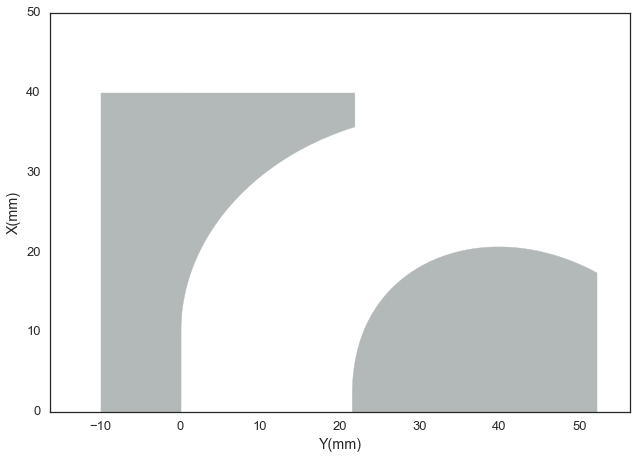

In [16]:
constraint = 3 #3, 5, 10
folder = '../data/model_data/lung_data/'
angle_names = [r'$\alpha$', r'$\beta$', r'$\gamma$']  
fig_lung = make_plot_boundaries()
# make_plots('ukf', fig_lung, show_predicted = False)
# make_plots('mlc', fig_lung)
make_plots('new', fig_lung, show_predicted = True)

if False:
    folder = '../data/model_data/figs/'
    file   = 'fig_lung_' + str(constraint) + '.pdf'
    fig_lung.savefig(folder + file, format = 'pdf', bbox_inches='tight')
    file   = 'fig_lung_tension_ukf.pdf'
    fig_tension_ukf.savefig(folder + file, format = 'pdf', bbox_inches='tight')
    file   = 'fig_lung_tension_mlc_' + str(constraint) + '.pdf'
    fig_tension_mlc.savefig(folder + file, format = 'pdf', bbox_inches='tight')
    file   = 'fig_lung_angles.pdf'
    fig_angles.savefig(folder + file, format = 'pdf', bbox_inches='tight')
